In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate a 2D Dataset (Two Moons)
We'll start by generating a simple 2D dataset, like the "two moons" shape, using scikit-learn:

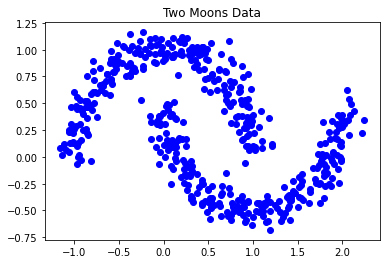

In [16]:
from datasets import (
    TwoMoonsDataset,
    TwoCirclesDataset,
    GaussianBlobsDataset,
    SwissRollDataset,
    SpiralDataset,
    StarDataset,
    HeartDataset,
    CircleDataset,
    LineDataset,
    WaveDataset,
)


twomoons_dataset = TwoMoonsDataset(n_samples=20, n_points=500, noise=0.1)

# Generate two moons data
data = next(iter(twomoons_dataset))

plt.scatter(data[:, 0], data[:, 1], c='blue')
plt.title('Two Moons Data')
plt.show()

In [25]:
from torch.utils.data import DataLoader



batch_size = 128

# Initialize the model, optimizer, and loss function
criterion = nn.MSELoss()
ddpm = DDPM(timesteps=timesteps, criterion=criterion)
optimizer = optim.Adam(ddpm.parameters(), lr=learning_rate)

# Create a DataLoader
dataloader = DataLoader(twomoons_dataset, batch_size=batch_size, shuffle=True)

## Define the DDPM Framework
Next, we'll define the core components of the DDPM: the forward process (adding noise) and the reverse process (denoising).

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim




class DDPM(nn.Module):
    def __init__(self, timesteps=1000, criterion=nn.MSELoss()):
        super(DDPM, self).__init__()
        self.criterion = criterion
        self.timesteps = timesteps
        self.betas = torch.linspace(0.0001, 0.02, timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]], axis=0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward_diffusion(self, x_0, t):
        noise = torch.randn_like(x_0)
        sqrt_alpha_cumprod_t = self.alphas_cumprod[t].sqrt().unsqueeze(1)
        sqrt_one_minus_alpha_cumprod_t = (1.0 - self.alphas_cumprod[t]).sqrt().unsqueeze(1)
        return sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

    def reverse_diffusion(self, x_t, t):
        mean = (1.0 / self.sqrt_recip_alphas[t]) * (x_t - self.betas[t] / (1.0 - self.alphas_cumprod[t]).sqrt() * self.model(x_t))
        noise = torch.randn_like(x_t) if t > 0 else 0
        return mean + (self.posterior_variance[t].sqrt() * noise)

    def loss(self, x_0, t):
        x_t, noise = self.forward_diffusion(x_0, t)
        predicted_noise = self.model(x_t)
        return self.criterion(predicted_noise, noise)


## Training the Model
Now, let's train the DDPM on the two moons dataset.

In [27]:

# Training loop
for epoch in range(epochs):
    for data in dataloader:
        x_0 = data
        t = torch.randint(0, timesteps, (batch_size,), device=data.device)
        
        loss = ddpm.loss(x_0, t)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

RuntimeError: The size of tensor a (128) must match the size of tensor b (500) at non-singleton dimension 1

## Sampling from the Model
After training, we can sample points from the model to reconstruct the original data distribution.

In [ ]:
def sample(ddpm, timesteps, num_samples=1000):
    x = torch.randn((num_samples, 2))
    for t in reversed(range(timesteps)):
        x = ddpm.reverse_diffusion(x, torch.tensor([t]))
    return x.detach().numpy()

samples = sample(ddpm, timesteps=timesteps)

plt.scatter(samples[:, 0], samples[:, 1], c='red')
plt.title('Generated Samples')
plt.show()


## Visualizing the Process
To visualize how the diffusion process perturbs the data and how the model denoises it, you can save intermediate images or create an animation.

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

line, = ax.plot([], [], 'ro')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    t = timesteps - i - 1
    samples = sample(ddpm, timesteps=timesteps, num_samples=100)
    line.set_data(samples[:, 0], samples[:, 1])
    return line,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=timesteps, interval=50, blit=True)
plt.show()
